##  Import libraries ##

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Open the file

In [2]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

## Get the keys

In [3]:
df = df.drop(df.columns[0], axis=1) # We are dropping the first coolumn because it is just an index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.7+ GB


## See how many the missing values are (they are 0.01% of the dataset, we can drop them)

In [4]:
# # Missing values
# missing_values = df.isnull().sum()
# print(missing_values)

# # Drop rows with the missing IDs
# df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
# df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
# df

# df['birth_year'].hist(bins=50, figsize=(20, 15))
# find the range of the 99% of the birth year

## Make a historgram of the birth years to see the distribution and keep the 99th percentile of the data

1950.0


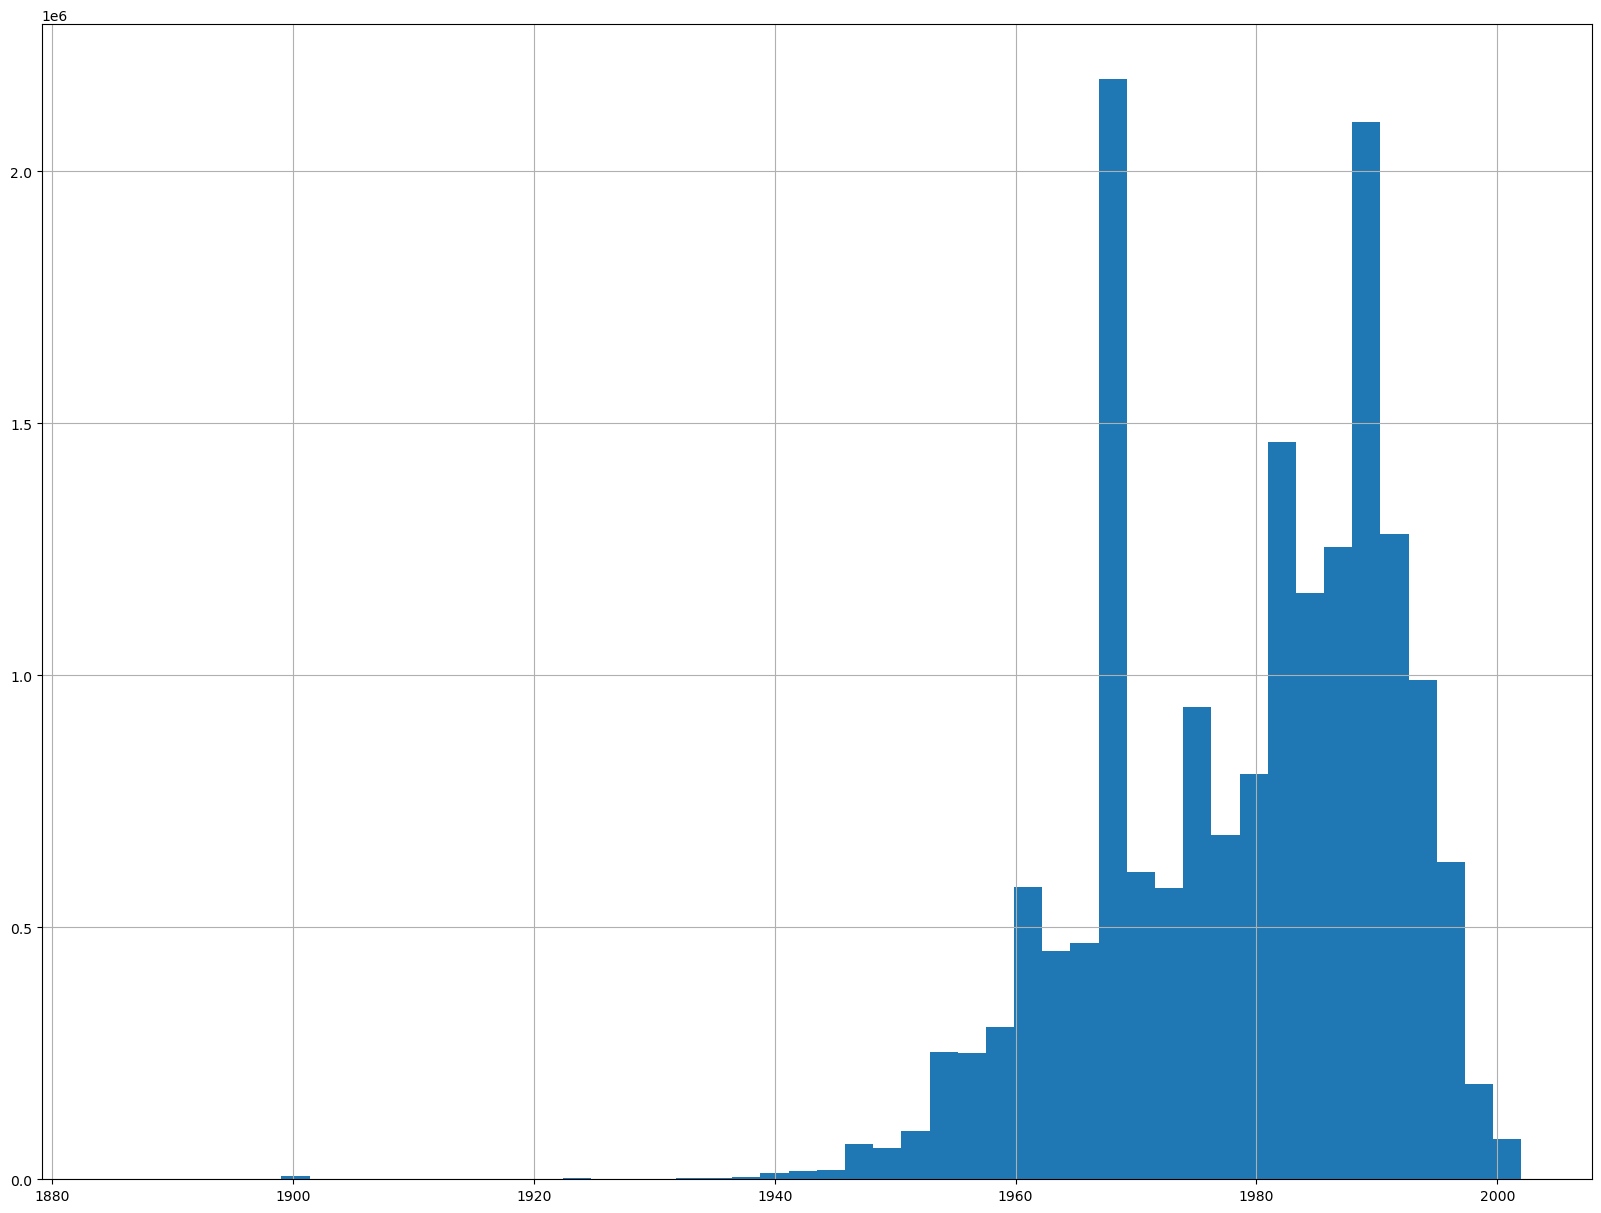

In [5]:

df.birth_year.hist(bins=50, figsize=(20, 15))
print(df['birth_year'].quantile(0.01))

## Drop the rows where birth_year was out of the 99th percentile

<class 'pandas.core.frame.DataFrame'>
Index: 17344288 entries, 0 to 17548338
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.8+ GB


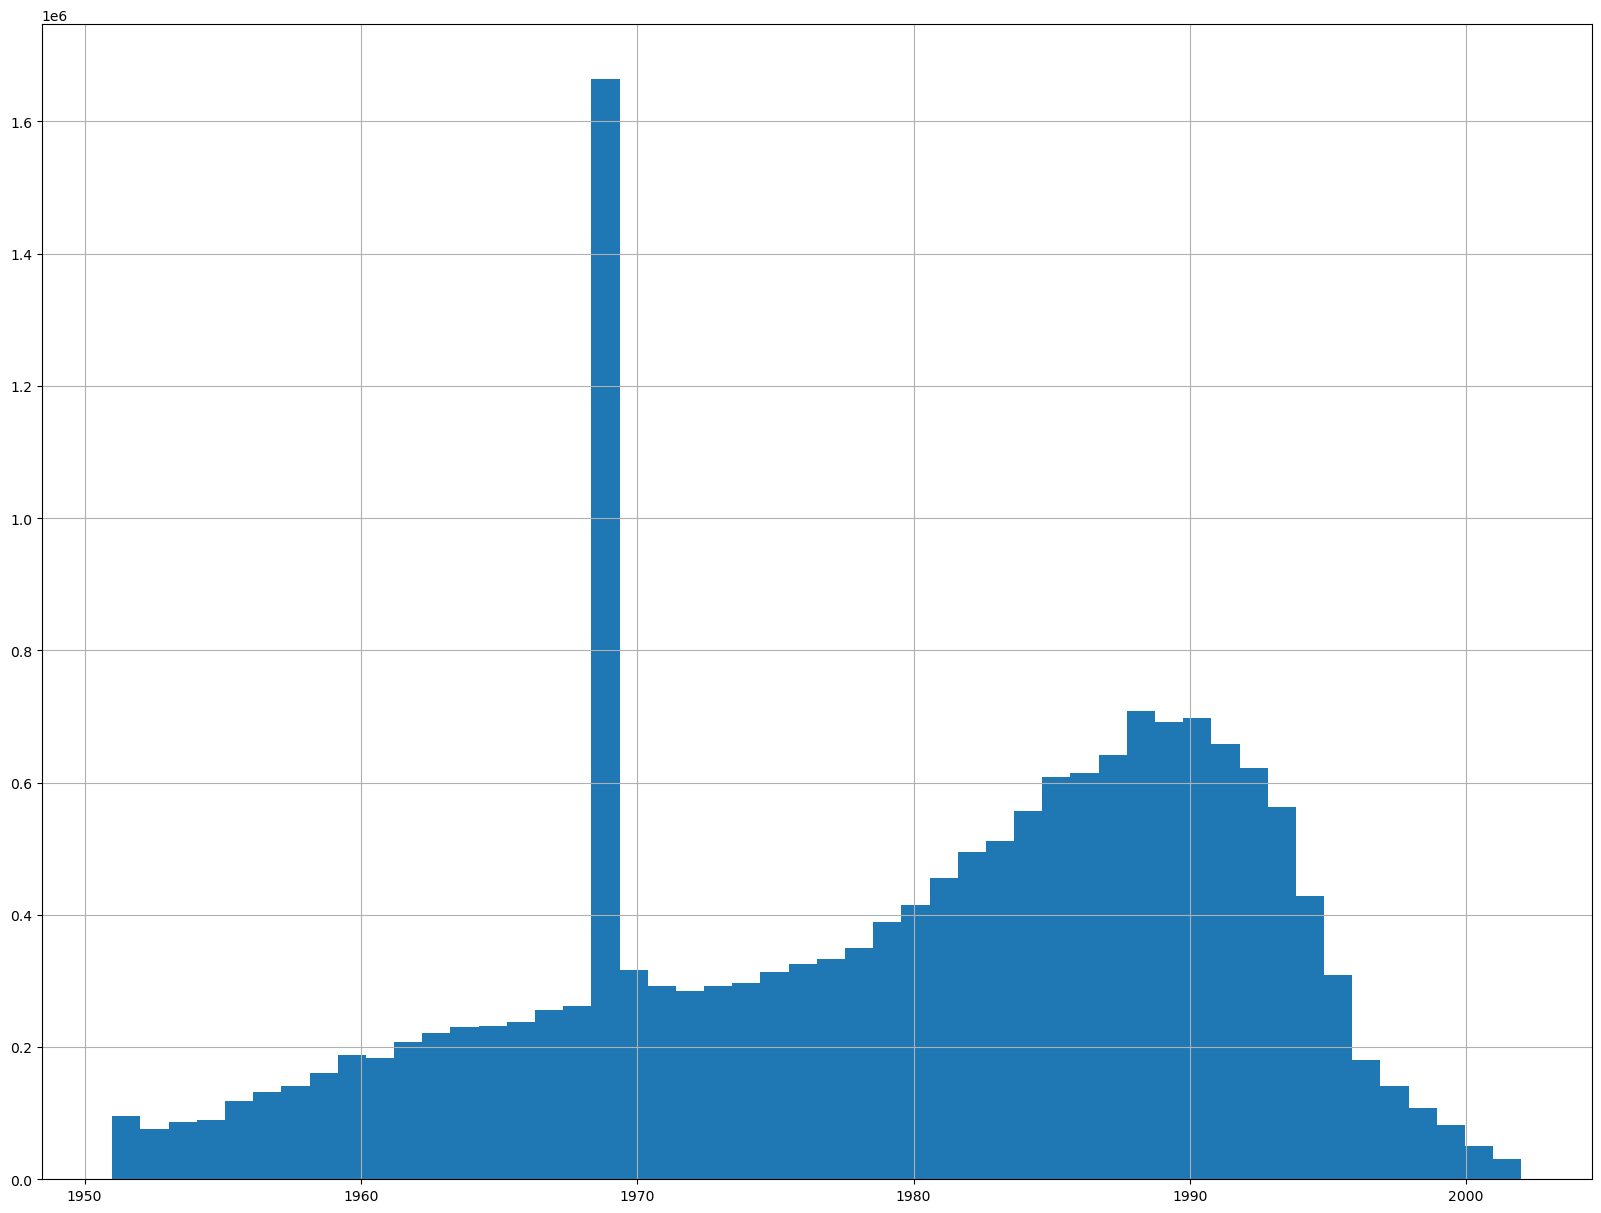

In [6]:
df = df[df['birth_year'] > df['birth_year'].quantile(0.01)]
df.birth_year.hist(bins=50, figsize=(20, 15))
df.info()

Explained variance from start_station_latitude_pca: 38.55%
Explained variance from start_station_longitude_pca: 21.51%
Explained variance from end_station_latitude_pca: 16.67%
Explained variance from end_station_longitude_pca: 16.01%
Explained variance from birth_year_pca: 5.3%
Explained variance from tripduration_pca: 1.96%


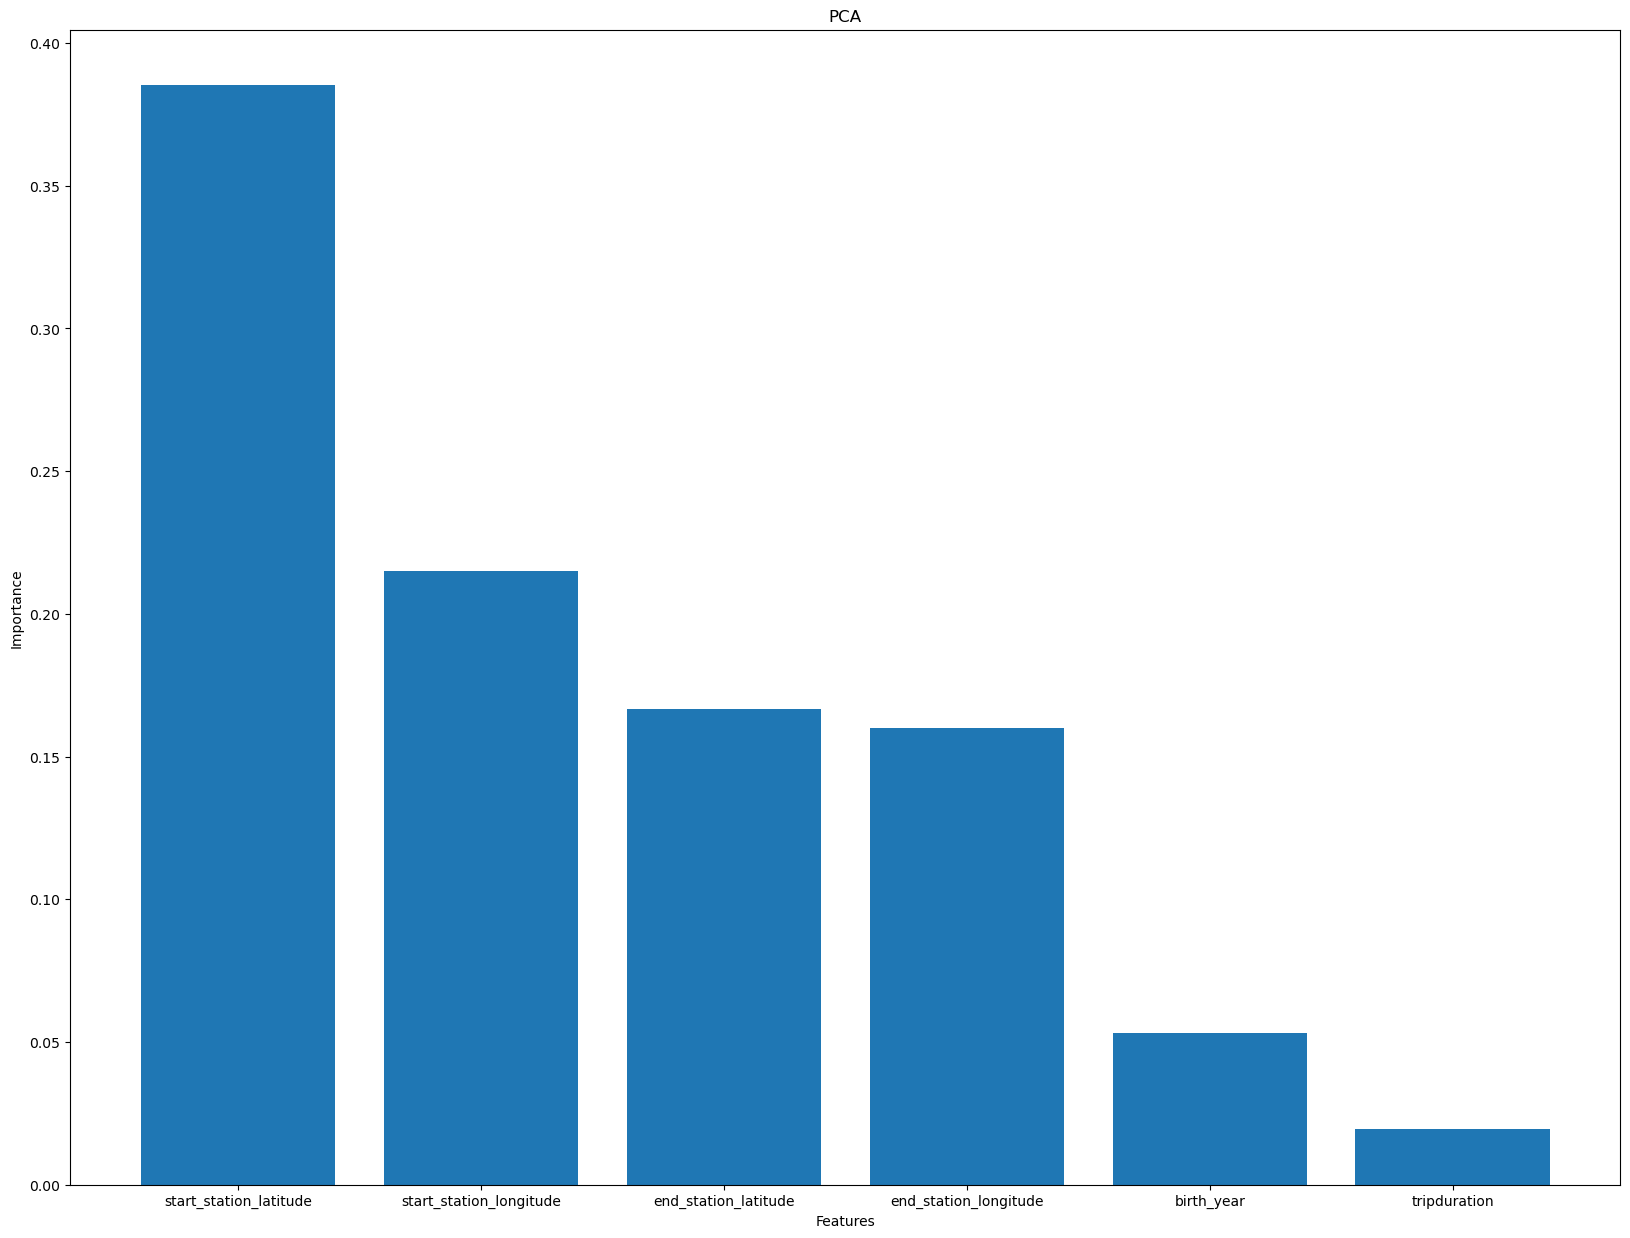

Explained variance from start_station_latitude_pca: 57.82%
Explained variance from start_station_longitude_pca: 31.3%
Explained variance from end_station_latitude_pca: 7.95%
Explained variance from end_station_longitude_pca: 2.94%


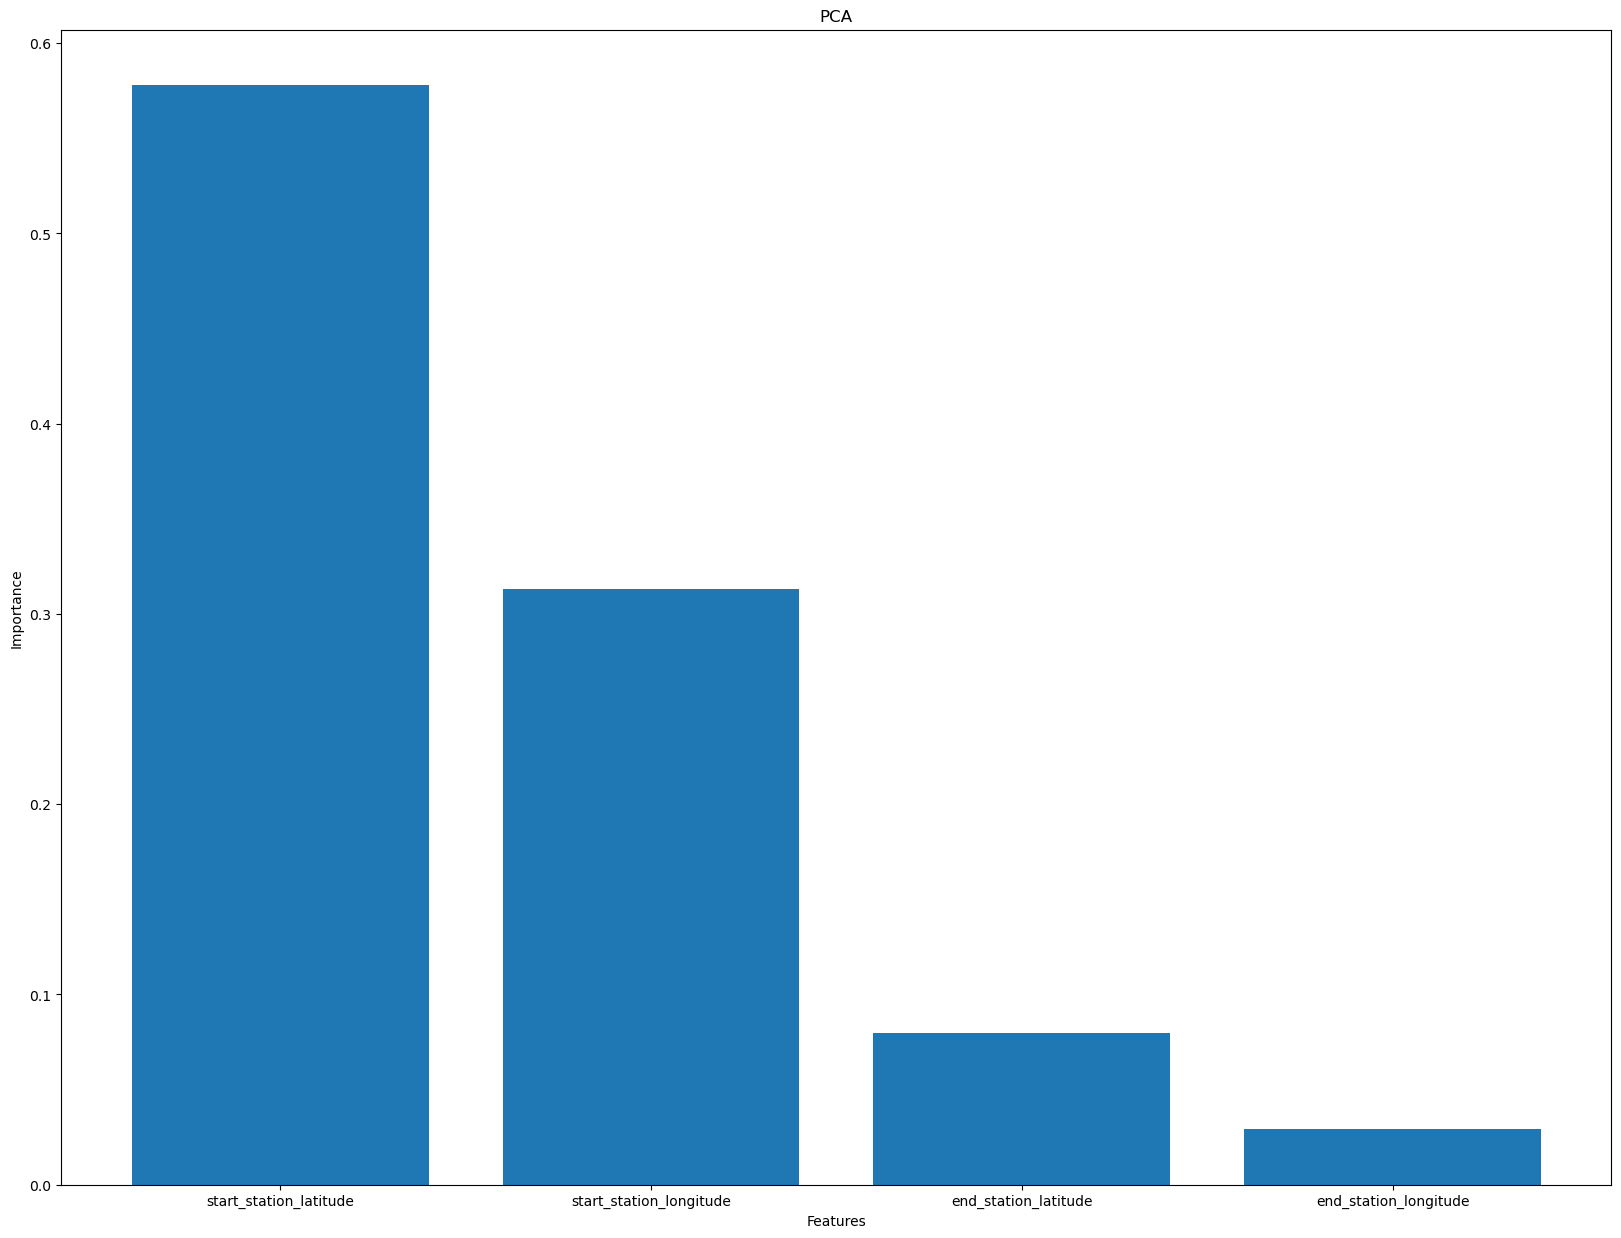

In [7]:
# Do PCA on the dataset to find the most important features
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration']])
scaled_df = pd.DataFrame(scaled_df, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])

# PCA using all the features
pca = PCA(n_components=6)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
# Name the features with the same names as the original dataframe adding the suffix '_pca'
pca_df = pd.DataFrame(pca_df, columns=['start_station_latitude_pca', 'start_station_longitude_pca', 'end_station_latitude_pca', 'end_station_longitude_pca', 'birth_year_pca', 'tripduration_pca'])
pca_df
# Show the importance of each feature
for v in pca.explained_variance_ratio_:
    index = np.where(pca.explained_variance_ratio_ == v)
    column_name = pca_df.columns[index]
    print(f'Explained variance from {column_name[0]}: {round(v*100,2)}%')
# Plot the importance of each feature a bit spaced out so we can see the names
plt.figure(figsize=(20, 15))
plt.bar(x=range(1, 7), height=pca.explained_variance_ratio_, tick_label=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('PCA')
plt.savefig('plots/pca.png')
plt.show()

# PCA using only the coordinates
pca = PCA(n_components=4)
pca.fit(scaled_df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']])
pca_df = pca.transform(scaled_df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']])
# Name the features with the same names as the original dataframe adding the suffix '_pca'
pca_df = pd.DataFrame(pca_df, columns=['start_station_latitude_pca', 'start_station_longitude_pca', 'end_station_latitude_pca', 'end_station_longitude_pca'])

# Show the importance of each feature
for v in pca.explained_variance_ratio_:
    index = np.where(pca.explained_variance_ratio_ == v)
    column_name = pca_df.columns[index]
    print(f'Explained variance from {column_name[0]}: {round(v*100,2)}%')
# Plot the importance of each feature a bit spaced out so we can see the names
plt.figure(figsize=(20, 15))
plt.bar(x=range(1, 5), height=pca.explained_variance_ratio_, tick_label=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('PCA')
plt.show()



/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly t

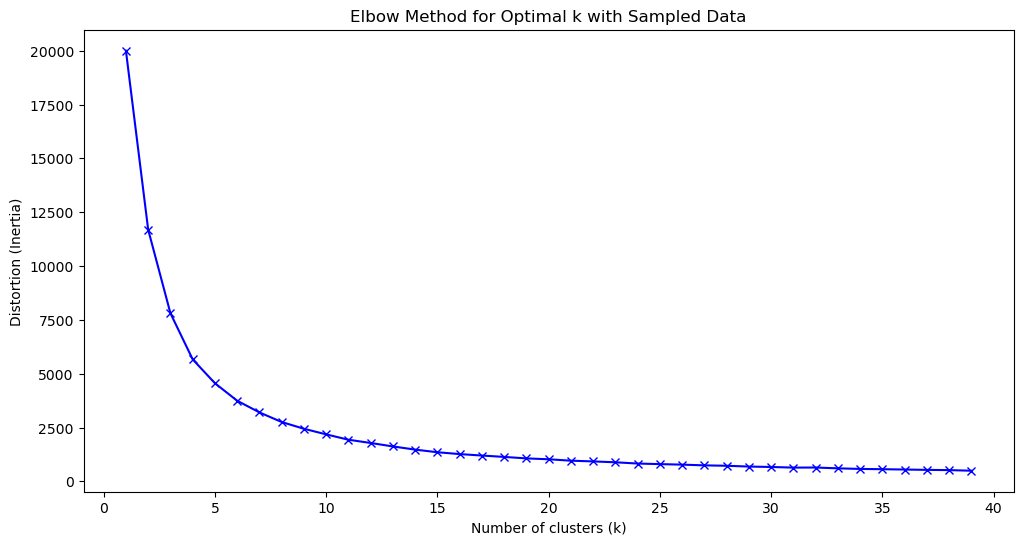

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

#this method is time consuming so instead of using the entire dataset to find the optimal number of clusters,I am working with a random sample.

sample_size = 10000 
df_sample = df.sample(n=sample_size, random_state=42)

# Extract coordinates from the sample
coordinates_sample = df_sample[['start_station_latitude', 'start_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
# coordinates_sample = coordinates_standardized

#Elbow method
distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


## Cluster by starting station coordinates

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17344288 entries, 0 to 17548338
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start_station_id         float64
 4   start_station_latitude   float64
 5   start_station_longitude  float64
 6   end_station_id           float64
 7   end_station_latitude     float64
 8   end_station_longitude    float64
 9   bikeid                   int64  
 10  usertype                 object 
 11  birth_year               int64  
 12  gender                   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.8+ GB


In [10]:
from sklearn.cluster import KMeans
X = coordinates_sample.values   # We are clustering using sample due to computational efficiency. In the final version we will use the entire dataset
# X = df[['start_station_latitude', 'start_station_longitude']].values
# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(X)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df_sample['cluster'] = kmeans.labels_

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Plot the clusters

In [11]:
#First before plotting we have to deal with the outliers 
#The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

lon_min = -79.76259
lat_min = 40.4774
lon_max = -71.18507
lat_max = 45.01585

# Store the stations that are within the boundaries
stations = df_sample[
    (df_sample['start_station_latitude'] > lat_min) &
    (df_sample['start_station_latitude'] < lat_max) &
    (df_sample['start_station_longitude'] > lon_min) &
    (df_sample['start_station_longitude'] < lon_max)
]

print(stations)

          tripduration                 starttime                  stoptime  \
7010776            274  2018-06-10 18:44:29.8120  2018-06-10 18:49:04.7750   
16271984           318  2018-11-24 16:49:38.5340  2018-11-24 16:54:56.6840   
9916843           1252  2018-08-07 08:01:34.1280  2018-08-07 08:22:26.1900   
12184806           458  2018-09-12 17:54:58.6070  2018-09-12 18:02:36.7050   
14784771           423  2018-10-23 08:27:03.1910  2018-10-23 08:34:06.5640   
...                ...                       ...                       ...   
9720879           1906  2018-08-03 18:52:50.4120  2018-08-03 19:24:36.8400   
316141             372  2018-01-26 19:42:07.5140  2018-01-26 19:48:19.9140   
3870881            932  2018-05-31 00:11:24.9700  2018-05-31 00:26:57.9570   
3950704           2071  2018-05-29 20:53:45.0700  2018-05-29 21:28:16.8160   
4362053            608  2018-05-07 18:21:48.7770  2018-05-07 18:31:57.0540   

          start_station_id  start_station_latitude  start_stati

In [12]:
# Plot the stations with an underlying map of New York City
subsampled_stations = stations.sample(n=1000, random_state=42)
title = 'Citi Bike Stations in New York City'
fig = px.scatter_mapbox(
    subsampled_stations,
    lat='start_station_latitude',
    lon='start_station_longitude',
    color='cluster',
    mapbox_style='carto-positron',
    zoom=9,
    width=1000,
    height=600
)
fig.update_layout(
    title=dict(
        text=title,
        x=0.5,  # Center the title horizontally
        xanchor='center',  # Anchor point for horizontal alignment
        font=dict(size=20)
    )
)
fig.show()

## Find the locations that are outliers (i.e, too far from the cluster centers) and remove them from the dataset

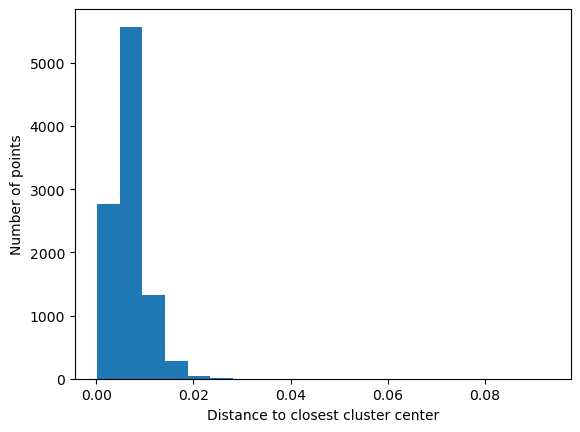

In [13]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(X)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

# Plot a histogram of the minimum distance to a cluster center
plt.hist(min_distance, bins=20)
plt.xlabel('Distance to closest cluster center')
plt.ylabel('Number of points')
plt.show()

In [14]:
threshold = 0.015

# For each cluster, get the distance of each point from its cluster center and drop the points that are too far away from it (more than the threshold)
print(df_sample['cluster'])




7010776     16
16271984     9
9916843     16
12184806    17
14784771    13
            ..
9720879      6
316141       0
3870881      5
3950704      5
4362053      9
Name: cluster, Length: 10000, dtype: int32


## Find the cluster with the most instances (the cluster with the biggest demand)

In [15]:
# Group the dataframe by 'cluster' and get the unique values of 'start_station_id' for each group
station_ids_by_cluster = df_sample.groupby('cluster')['start_station_id'].unique()

# Loop through each group and for each station ID, filter the dataframe to get all the instances of that station in the cluster and sum them together
cluster_instances = {}
for cluster, station_ids in station_ids_by_cluster.items():
    total_instances = 0
    for station_id in station_ids:
        station_instances = df_sample[(df_sample['cluster'] == cluster) & (df_sample['start_station_id'] == station_id)]
        total_instances += len(station_instances)
    cluster_instances[cluster] = total_instances

# Sort the dictionary by values in descending order
sorted_clusters = sorted(cluster_instances.items(), key=lambda x: x[1], reverse=True)

# Print the clusters in descending order by instances
# for cluster, instances in sorted_clusters:
#     print('Cluster', cluster, 'has', instances, 'instances')

print(f'Most important cluster: {sorted_clusters[0][0]}')
print(f'Number of instances: {sorted_clusters[0][1]}')

# Sum the number of instances for all clusters
print('------------------------------------------------------------------------------------------------------------------------')
print(f'Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...')
total_instances = sum(cluster_instances.values())
print(f'Total number of instances: {total_instances}')
print(f'Percentage of instances in the most important cluster: {round(sorted_clusters[0][1] / total_instances * 100, 2)}%')
print(f'Number of all instances in the dataframe: {len(df)}')

Most important cluster: 0
Number of instances: 920
------------------------------------------------------------------------------------------------------------------------
Validating that the number of instances in all clusters (calculated) is equal to the total number of instances in the dataframe...
Total number of instances: 9998
Percentage of instances in the most important cluster: 9.2%
Number of all instances in the dataframe: 17344288


In [16]:
#Trasform startime and stoptimeinto datetime data
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 7010776 to 4362053
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             10000 non-null  int64  
 1   starttime                10000 non-null  object 
 2   stoptime                 10000 non-null  object 
 3   start_station_id         9998 non-null   float64
 4   start_station_latitude   10000 non-null  float64
 5   start_station_longitude  10000 non-null  float64
 6   end_station_id           9998 non-null   float64
 7   end_station_latitude     10000 non-null  float64
 8   end_station_longitude    10000 non-null  float64
 9   bikeid                   10000 non-null  int64  
 10  usertype                 10000 non-null  object 
 11  birth_year               10000 non-null  int64  
 12  gender                   10000 non-null  int64  
 13  cluster                  10000 non-null  int32  
dtypes: float64(6), int3

## Now let's try DBSCAN

In [20]:
# Clustering with DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Extract coordinates from the sample
coordinates_sample = df_sample[['start_station_latitude', 'start_station_longitude']]
#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
coordinates_sample = coordinates_standardized

# Cluster the data into 20 clusters
dbscan = DBSCAN(eps=0.3, min_samples=10).fit(coordinates_standardized)

# Get the cluster labels
labels = dbscan.labels_

# Add the cluster labels to the dataframe
df_sample['cluster_dbscan'] = labels

# Plot the stations with an underlying map of New York City
subsampled_stations_dbscan = df_sample.sample(n=1000, random_state=42)
title = 'Citi Bike Stations in New York City (DBSCAN clustering)))'
fig = px.scatter_mapbox(
    subsampled_stations_dbscan,
    lat='start_station_latitude',
    lon='start_station_longitude',
    color='cluster_dbscan',
    mapbox_style='carto-positron',
    zoom=9,
    width=1000,
    height=600
)
fig.update_layout(
    title=dict(
        text=title,
        x=0.5,  # Center the title horizontally
        xanchor='center',  # Anchor point for horizontal alignment
        font=dict(size=20)
    )
)
fig.show()


## Create time series of the duration of the trip

In [23]:
df_sample.tripduration

7010776      274
16271984     318
9916843     1252
12184806     458
14784771     423
            ... 
9720879     1906
316141       372
3870881      932
3950704     2071
4362053      608
Name: tripduration, Length: 10000, dtype: int64

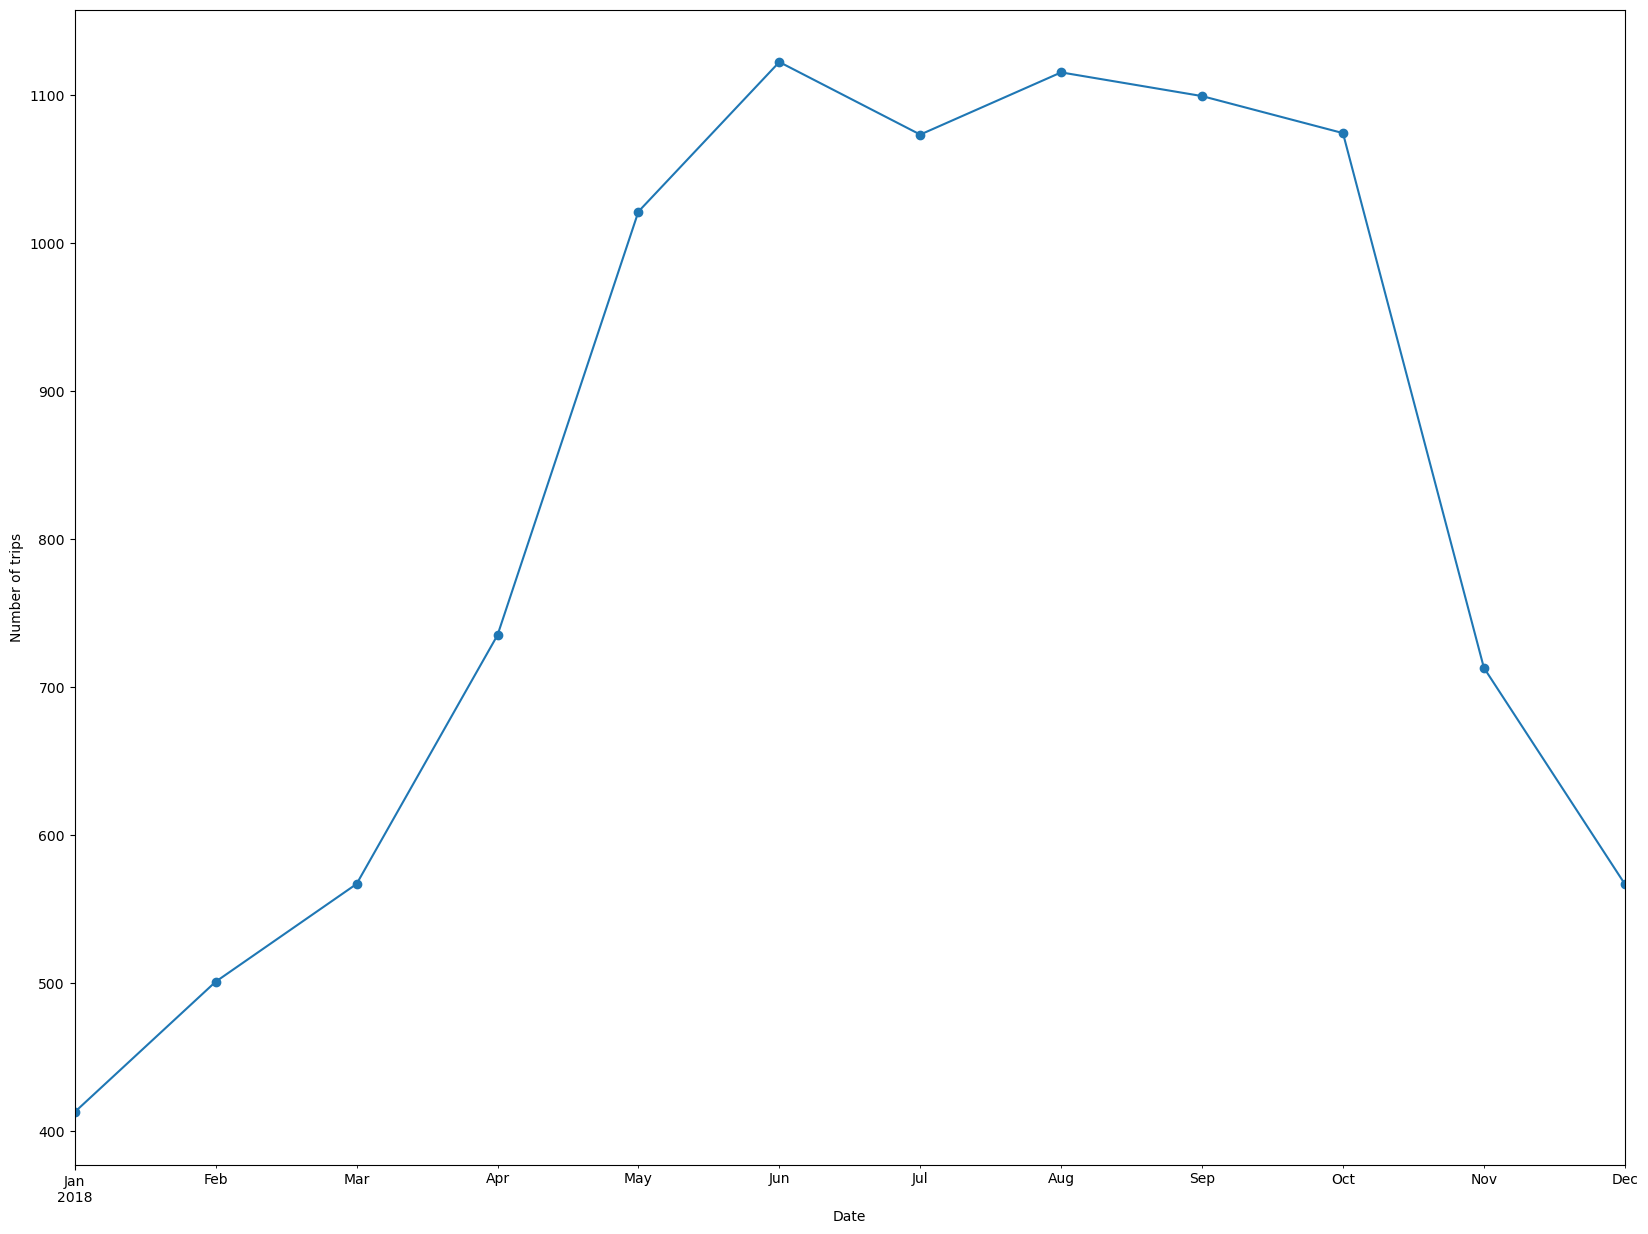

In [29]:
# Convert start time and stoptime to datetime
df_sample['starttime'] = pd.to_datetime(df_sample['starttime'])
df_sample['stoptime'] = pd.to_datetime(df_sample['stoptime'])

# Time series analysis
# Extract the start time and trip duration columns
time_series = df_sample[['starttime', 'tripduration']]
# Set the start time as the index
time_series = time_series.set_index('starttime')
# Resample the data by day and sum the trip duration
time_series = time_series.resample('M').size()
# Plot the time series using linear interpolation
time_series.plot(figsize=(20, 15), marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.savefig('plots/time_series.png')
plt.show()

